In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import warnings
warnings.simplefilter('ignore')

Data Loading/Inspection

In [97]:
df=pd.read_csv('lung_disease_data.csv')
print("Duplicate rows:", df.duplicated().sum())
print(df['Recovered'].value_counts())
print(df.isnull().sum())
print(df.head())
print(df.info())
print(df.describe(include='all'))
print(df.dtypes)

Duplicate rows: 91
Recovered
Yes    2492
No     2408
Name: count, dtype: int64
Age                300
Gender             300
Smoking Status     300
Lung Capacity      300
Disease Type       300
Treatment Type     300
Hospital Visits    300
Recovered          300
dtype: int64
    Age  Gender Smoking Status  Lung Capacity Disease Type Treatment Type  \
0  71.0  Female             No           4.49         COPD        Therapy   
1  34.0  Female            Yes            NaN   Bronchitis        Surgery   
2  80.0    Male            Yes           1.95         COPD            NaN   
3  40.0  Female            Yes            NaN   Bronchitis     Medication   
4  43.0    Male            Yes           4.60         COPD        Surgery   

   Hospital Visits Recovered  
0             14.0       Yes  
1              7.0        No  
2              4.0       Yes  
3              1.0        No  
4              NaN       Yes  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
D

In [ ]:
numericals=df.select_dtypes(include=['int64', 'float64']).columns
categoricals=df.select_dtypes(include='object').columns

for col in categoricals:
    df[col]=df[col].fillna(df[col].mode()[0])

imputer=KNNImputer(n_neighbors=5)
df[numericals]=imputer.fit_transform(df[numericals])

df=df.drop_duplicates()

print("Missing values post cleaning: \n", df.isnull().sum())
print("\nDuplicate rows post cleaning:", df.duplicated().sum())
print(df.info())
print(df.describe(include='all'))

Missing values post cleaning: 
 Age                0
Gender             0
Smoking Status     0
Lung Capacity      0
Disease Type       0
Treatment Type     0
Hospital Visits    0
Recovered          0
dtype: int64

Duplicate rows post cleaning: 0
<class 'pandas.core.frame.DataFrame'>
Index: 5091 entries, 0 to 5194
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              5091 non-null   float64
 1   Gender           5091 non-null   object 
 2   Smoking Status   5091 non-null   object 
 3   Lung Capacity    5091 non-null   float64
 4   Disease Type     5091 non-null   object 
 5   Treatment Type   5091 non-null   object 
 6   Hospital Visits  5091 non-null   float64
 7   Recovered        5091 non-null   object 
dtypes: float64(3), object(5)
memory usage: 358.0+ KB
None
                Age  Gender Smoking Status  Lung Capacity Disease Type  \
count   5091.000000    5091           5091    5091.000000   

EDA

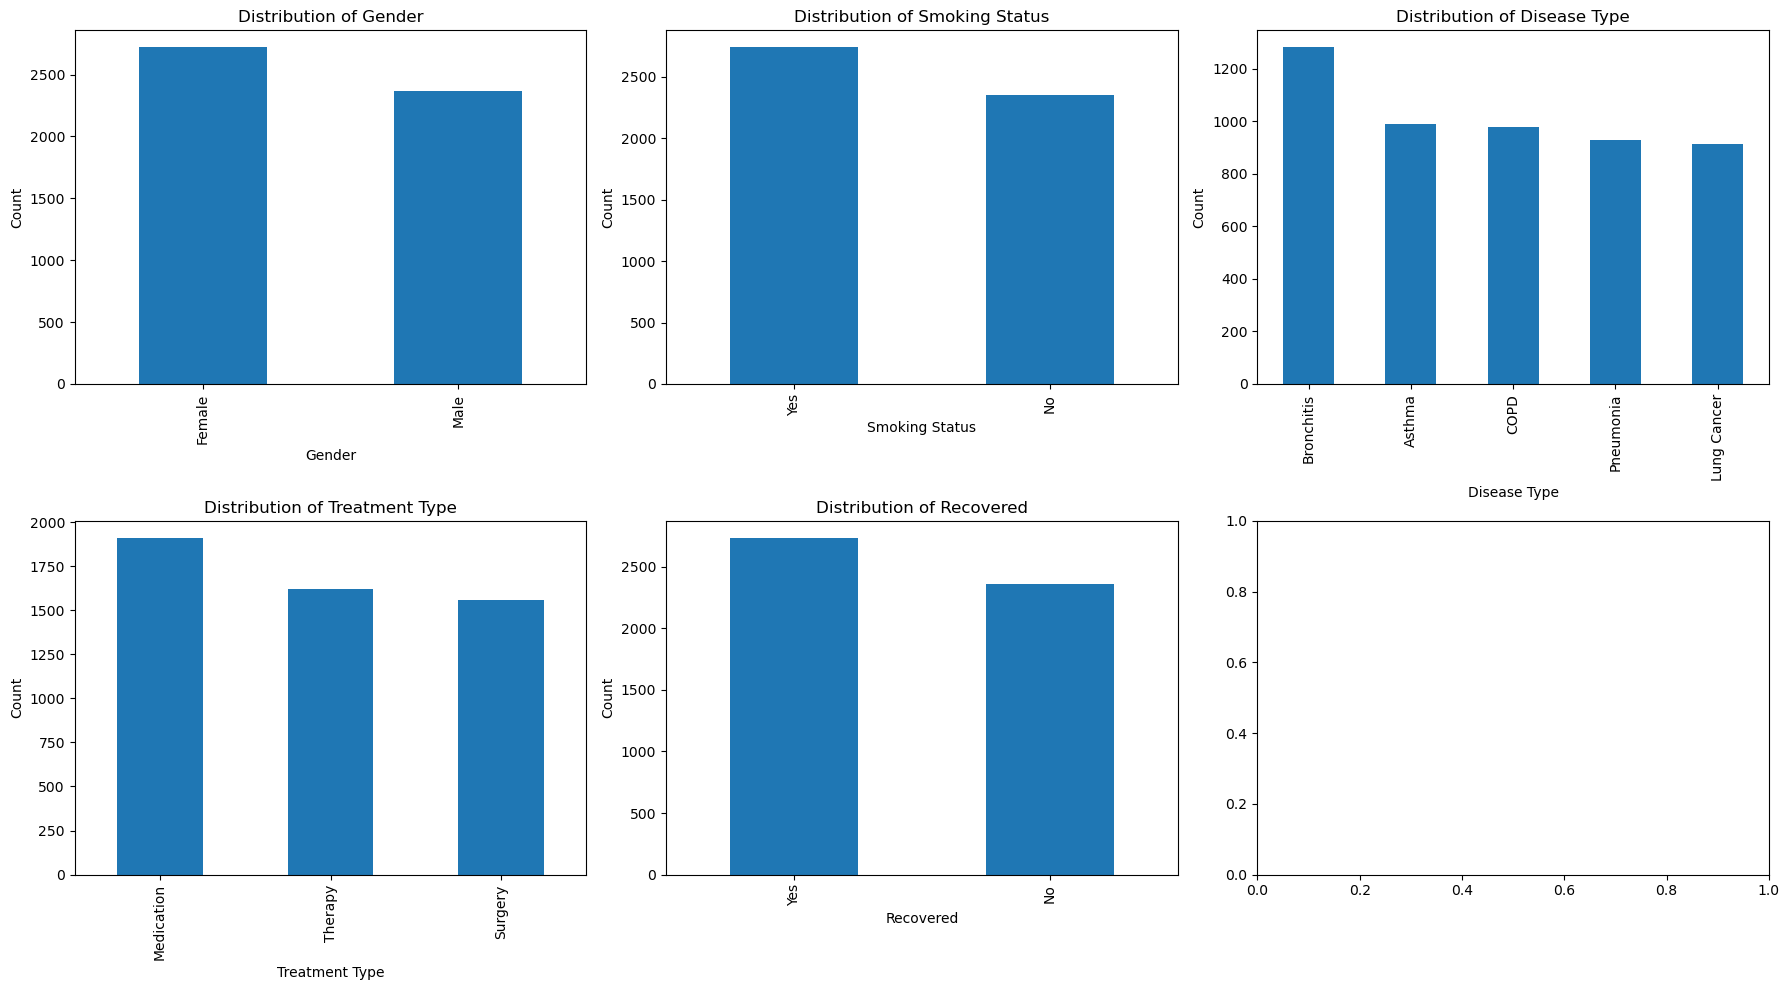

In [99]:
categoricals=['Gender', 'Smoking Status', 'Disease Type', 'Treatment Type', 'Recovered']
fig, axs=plt.subplots(2, 3, figsize=(18, 10))
axs=axs.flatten()
for i, col in enumerate(categoricals):
    df[col].value_counts().plot(kind='bar', ax=axs[i])
    axs[i].set_title(f'Distribution of {col}')
    axs[i].set_ylabel('Count')
    axs[i].set_xlabel(col)

plt.tight_layout()
plt.show()

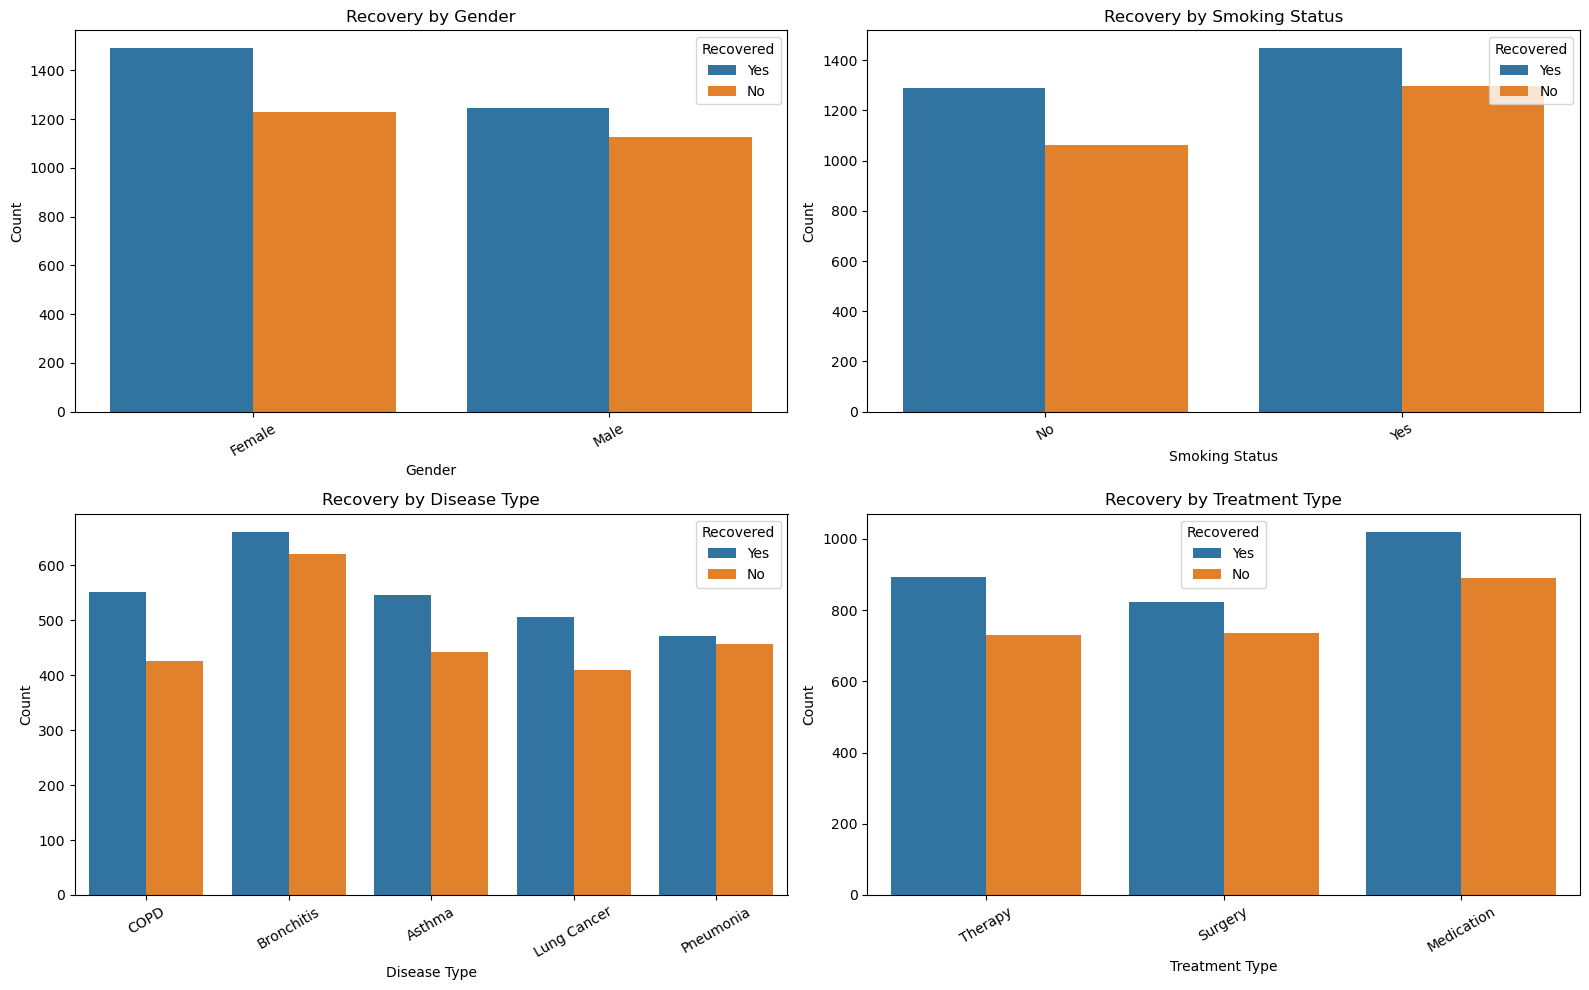

In [100]:
categoricals=['Gender', 'Smoking Status', 'Disease Type', 'Treatment Type']
fig, axs=plt.subplots(2, 2, figsize=(16, 10))
axs=axs.flatten()
for i, col in enumerate(categoricals):
    sns.countplot(data=df, x=col, hue='Recovered', ax=axs[i])
    axs[i].set_title(f'Recovery by {col}')
    axs[i].set_ylabel('Count')
    axs[i].set_xlabel(col)
    axs[i].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

In [101]:
for feature in categoricals:
    print(f"\nChi-squared test for: {feature}")
    contingency=pd.crosstab(df[feature], df['Recovered'])
    chi2, p, dof, expected=chi2_contingency(contingency)
    print(f"Chi-squared statistic: {chi2:.2f}")
    print(f"Degrees of freedom: {dof}")
    print(f"p-value: {p:.4f}")
    
    if p<0.05:
        print("Statistically significant relationship with Recovery")
    else:
        print("No significant relationship with Recovery")


Chi-squared test for: Gender
Chi-squared statistic: 2.44
Degrees of freedom: 1
p-value: 0.1183
No significant relationship with Recovery

Chi-squared test for: Smoking Status
Chi-squared statistic: 2.15
Degrees of freedom: 1
p-value: 0.1422
No significant relationship with Recovery

Chi-squared test for: Disease Type
Chi-squared statistic: 9.99
Degrees of freedom: 4
p-value: 0.0406
Statistically significant relationship with Recovery

Chi-squared test for: Treatment Type
Chi-squared statistic: 1.75
Degrees of freedom: 2
p-value: 0.4172
No significant relationship with Recovery


In [102]:
numericals=['Age', 'Lung Capacity', 'Hospital Visits']
print(df[numericals].describe())

               Age  Lung Capacity  Hospital Visits
count  5091.000000    5091.000000      5091.000000
mean     54.484983       3.502794         7.528919
std      19.617349       1.425176         3.901815
min      20.000000       1.000000         1.000000
25%      38.000000       2.290000         4.000000
50%      54.400000       3.490000         7.800000
75%      71.000000       4.735000        11.000000
max      89.000000       6.000000        14.000000


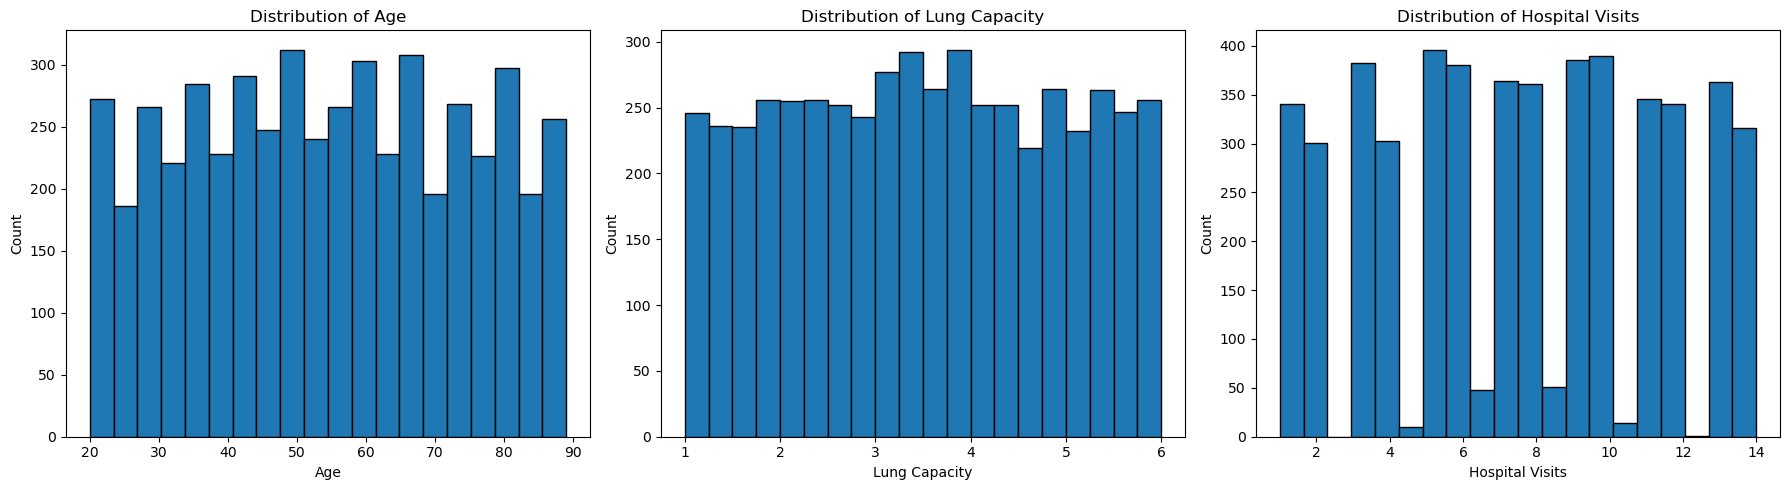

In [103]:
fig, axs=plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(numericals):
    axs[i].hist(df[col], bins=20, edgecolor='black')
    axs[i].set_title(f'Distribution of {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

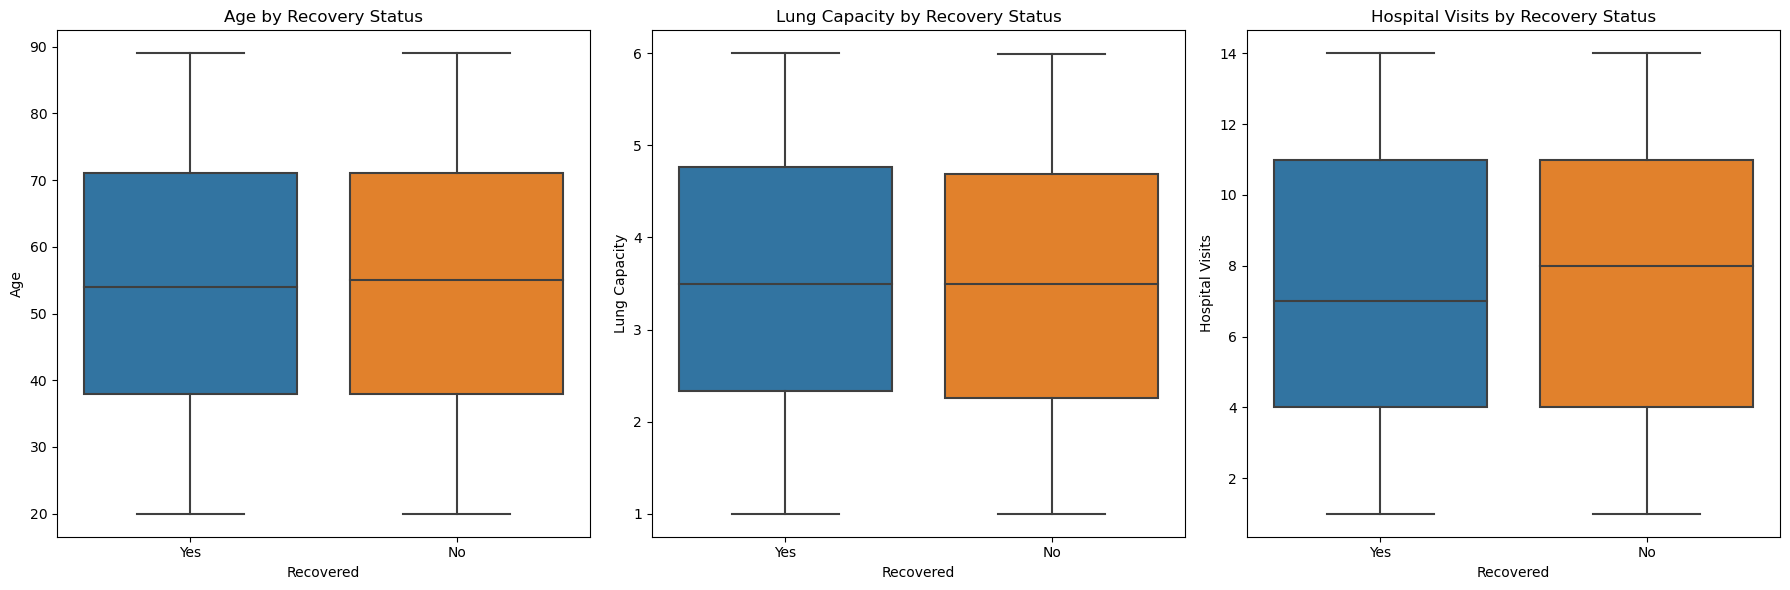

In [104]:
fig, axs=plt.subplots(1, 3, figsize=(18, 6))
for i, col in enumerate(numericals):
    sns.boxplot(data=df, x='Recovered', y=col, ax=axs[i])
    axs[i].set_title(f'{col} by Recovery Status')
    axs[i].set_xlabel('Recovered')
    axs[i].set_ylabel(col)

plt.tight_layout()
plt.show()

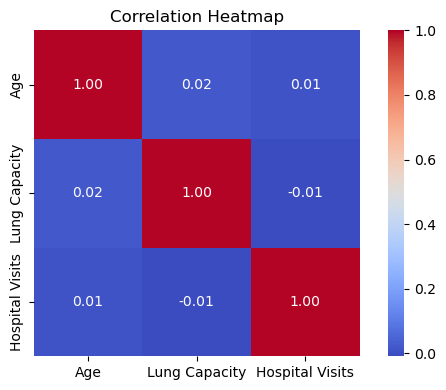

In [105]:
numeric_df=df[numericals]
corr_matrix=numeric_df.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

Preprocessing/encoding

In [ ]:
#target variable encodiing
df['Recovered']=df['Recovered'].map({'Yes': 1, 'No': 0})
#grouping features by there data types
cat_cols=df.select_dtypes(include='object').columns.tolist()
num_cols=df.select_dtypes(include=['int64', 'float64']).drop('Recovered', axis=1).columns.tolist()
#encoding categorical variables and scaling numerical variables
encoded=pd.DataFrame(OneHotEncoder(drop='first', sparse=False).fit_transform(df[cat_cols]))
scaled=pd.DataFrame(StandardScaler().fit_transform(df[num_cols]))
#recombining processed data
df_model=pd.concat([scaled, encoded], axis=1)
df_model['Recovered'] = df['Recovered'].values

print("Encoded categorical data:")
print(encoded.head())
print("\nScaled numerical data:")
print(scaled.head())

Encoded categorical data:
     0    1    2    3    4    5    6    7
0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0
1  0.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0
2  1.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0
3  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
4  1.0  1.0  0.0  1.0  0.0  0.0  1.0  0.0

Scaled numerical data:
          0         1         2
0  0.841940  0.692759  1.658643
1 -1.044330 -0.887552 -0.135571
2  1.300763 -1.089652 -0.904519
3 -0.738449  0.711004 -1.673468
4 -0.585508  0.769950  0.325799


Test/Train Split

In [107]:
X=df_model.drop('Recovered', axis=1)
y=df_model['Recovered']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model Building

In [ ]:
models={
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False)}

for name, model in models.items():
    model.fit(X_train.values, y_train.values)
    y_pred=model.predict(X_test.values)
    y_train_pred=model.predict(X_train.values)
    cv_scores=cross_val_score(model, X_train.values, y_train.values, cv=5)

    print(f'{name} CV accuracy: mean = {cv_scores.mean():.4f}, std = {cv_scores.std():.4f}')
    print(f'{name} Training classification report:\n{classification_report(y_train, y_train_pred)}')
    print(f'{name} Test classification report:\n{classification_report(y_test, y_pred)}')

Logistic Regression CV accuracy: mean = 0.5169, std = 0.0103
Logistic Regression Training classification report:
              precision    recall  f1-score   support

           0       0.53      0.12      0.20      1904
           1       0.54      0.90      0.68      2168

    accuracy                           0.54      4072
   macro avg       0.53      0.51      0.44      4072
weighted avg       0.53      0.54      0.45      4072

Logistic Regression Test classification report:
              precision    recall  f1-score   support

           0       0.56      0.13      0.21       452
           1       0.57      0.92      0.70       567

    accuracy                           0.57      1019
   macro avg       0.57      0.52      0.46      1019
weighted avg       0.57      0.57      0.49      1019

Random Forest CV accuracy: mean = 0.5174, std = 0.0163
Random Forest Training classification report:
              precision    recall  f1-score   support

           0       1.00      

Hyperparameter Tuning

In [109]:
models={
    'Logistic Regression': (LogisticRegression(class_weight='balanced', max_iter=1000), {'C': [0.1, 0.5, 1, 5], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}),
    'Random Forest': (RandomForestClassifier(random_state=42), {'n_estimators': [200, 300, 400], 'max_depth': [15, 20, 25], 'min_samples_split': [2, 4], 'max_features': ['sqrt', 'log2']}),
    'XGBoost': (XGBClassifier(), {'n_estimators': [300, 400], 'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [3, 4, 5], 'subsample': [0.8, 1.0], 'gamma': [0, 0.1, 0.3]})}

model_performance=[]
for name, (model, params) in models.items():
    grid=GridSearchCV(model, params, cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train.values, y_train.values)
    best_model=grid.best_estimator_
    y_pred_test=best_model.predict(X_test.values)
    y_pred_train=best_model.predict(X_train.values)

    model_performance.append({
        'Model': name,
        'Train accuracy': accuracy_score(y_train, y_pred_train),
        'Test accuracy': accuracy_score(y_test, y_pred_test),
        'Train precision': precision_score(y_train, y_pred_train),
        'Test precision': precision_score(y_test, y_pred_test),
        'Train recall': recall_score(y_train, y_pred_train),
        'Test recall': recall_score(y_test, y_pred_test),
        'Train F1': f1_score(y_train, y_pred_train),
        'Test F1': f1_score(y_test, y_pred_test)})

summary_df = pd.DataFrame(model_performance)
print("\nSummary table:")
print(summary_df)
print("Best params:", grid.best_params_)


Summary table:
                 Model  Train accuracy  Test accuracy  Train precision  \
0  Logistic Regression        0.520383       0.522080         0.552930   
1        Random Forest        0.994352       0.540726         0.991747   
2              XGBoost        0.619843       0.543670         0.600000   

   Test precision  Train recall  Test recall  Train F1   Test F1  
0        0.574627      0.517989     0.543210  0.534889  0.558477  
1        0.576983      0.997694     0.654321  0.994711  0.613223  
2        0.564394      0.857934     0.788360  0.706150  0.657837  
Best params: {'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}


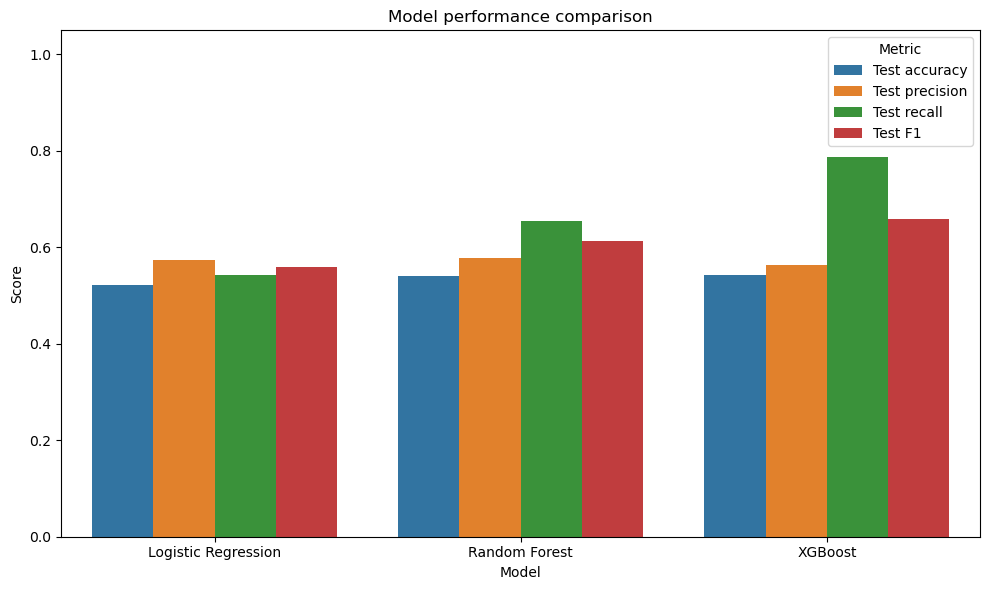

In [110]:
metrics_to_plot=['Test accuracy', 'Test precision', 'Test recall', 'Test F1']
summary_melted=summary_df.melt(id_vars='Model', value_vars=metrics_to_plot,
                                 var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=summary_melted, x='Model', y='Score', hue='Metric')
plt.title('Model performance comparison')
plt.ylim(0, 1.05)
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()